Importing Liraries

In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    RandomizedSearchCV
)

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix
)

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier
)

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from imblearn.over_sampling import SMOTE


import joblib


print("All libraries imported successfully ✔️")


All libraries imported successfully ✔️


Loading the dataset

In [2]:
df = pd.read_csv("diabetes.csv")
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Data insight

In [3]:
df.shape

(768, 9)

In [4]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


<Axes: xlabel='BMI', ylabel='Density'>

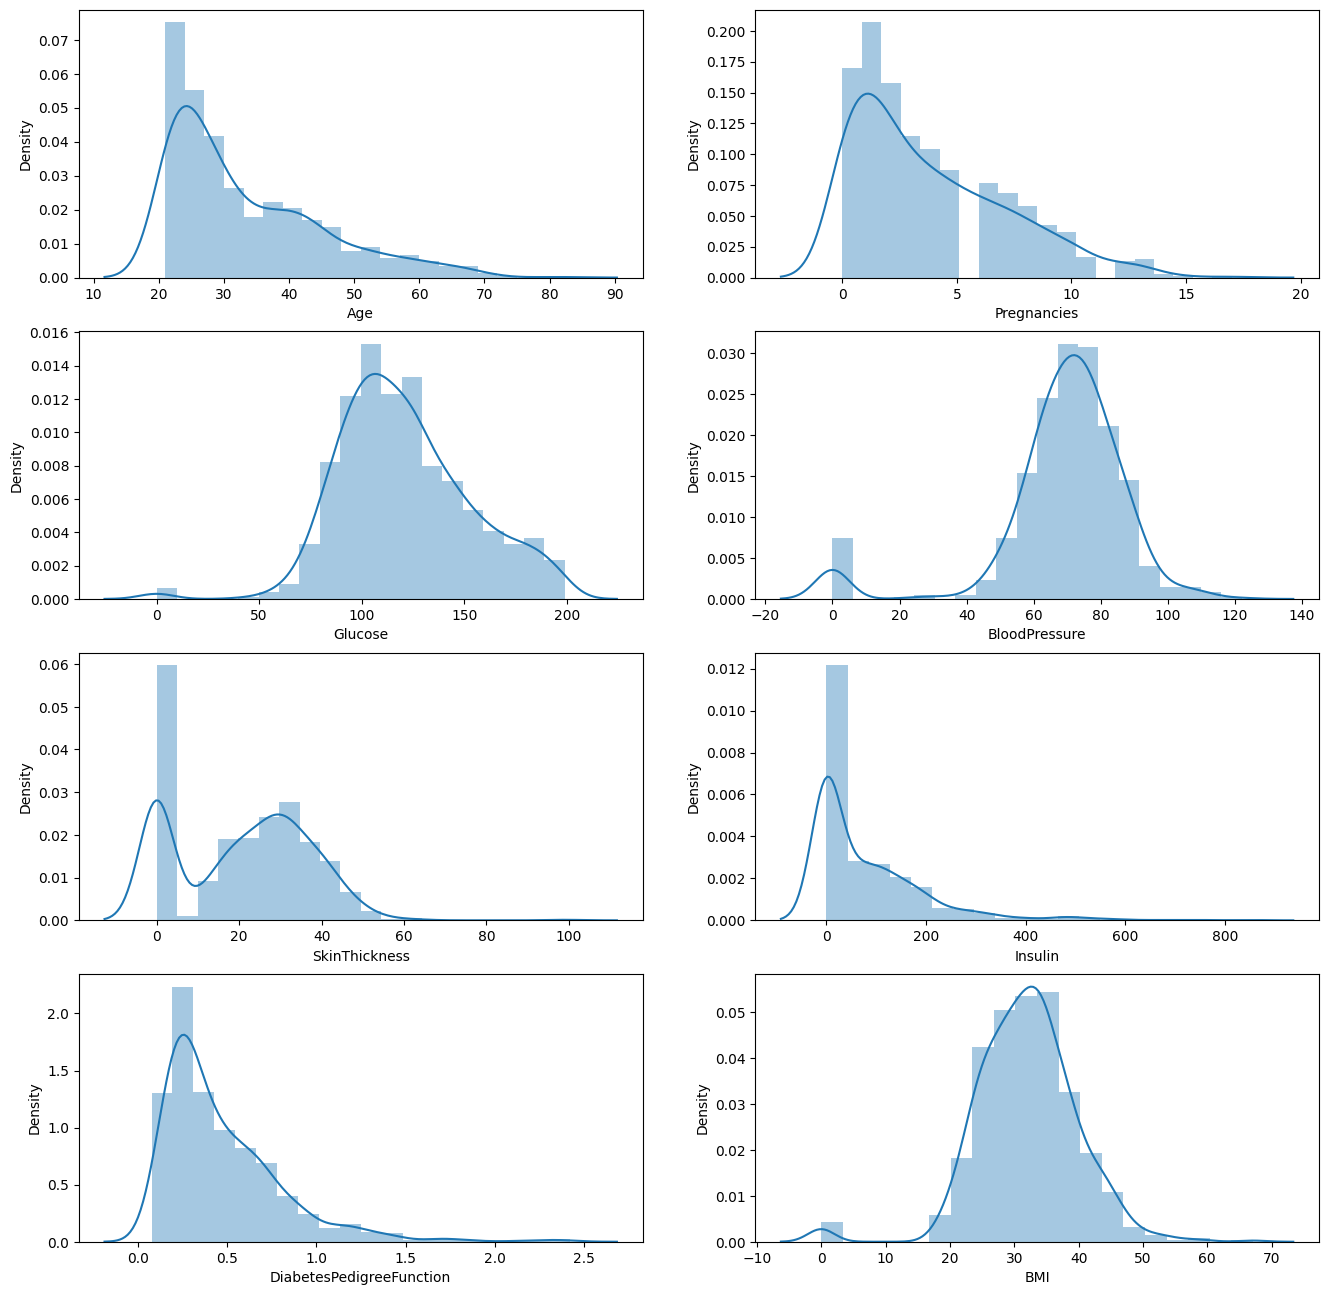

In [5]:
fig, ax = plt.subplots(4,2, figsize=(16,16))
sns.distplot(df.Age, bins = 20, ax=ax[0,0]) 
sns.distplot(df.Pregnancies, bins = 20, ax=ax[0,1]) 
sns.distplot(df.Glucose, bins = 20, ax=ax[1,0]) 
sns.distplot(df.BloodPressure, bins = 20, ax=ax[1,1]) 
sns.distplot(df.SkinThickness, bins = 20, ax=ax[2,0])
sns.distplot(df.Insulin, bins = 20, ax=ax[2,1])
sns.distplot(df.DiabetesPedigreeFunction, bins = 20, ax=ax[3,0]) 
sns.distplot(df.BMI, bins = 20, ax=ax[3,1]) 

Missing Data

In [6]:
cols_with_zero_as_nan = [
    "Glucose",
    "BloodPressure",
    "SkinThickness",
    "Insulin",
    "BMI"
]

for col in cols_with_zero_as_nan:
    df[col] = df[col].replace(0, np.nan)
df.isnull().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

In [7]:
for col in cols_with_zero_as_nan:
    df[col] = df[col].fillna(df[col].median())
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [8]:
df_fe = df.copy()

df_fe["Age_Group"] = pd.cut(
    df_fe["Age"], bins=[0,25,35,45,60,100], labels=["<25","25-35","35-45","45-60","60+"]
)
df_fe["BMI_Category"] = pd.cut( 
    df_fe["BMI"], bins=[0,18.5,25,30,100], labels=["Under","Normal","Over","Obese"]
)

df_fe["Glucose_Risk"] = pd.cut(
    df_fe["Glucose"], bins=[0,99,125,200], labels=["Normal","Prediabetes","Diabetes"]
)

df_fe["BMI*Age"] = df_fe["BMI"] * df_fe["Age"]
df_fe["Glucose*Preg"] = df_fe["Glucose"] * df_fe["Pregnancies"]


df_fe = pd.get_dummies(df_fe, drop_first=True)



Outlier Handling

In [9]:
def outlier_bounds(col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return lower, upper


In [10]:
numeric_cols = df.select_dtypes(include='number').columns

for col in numeric_cols:
    low, up = outlier_bounds(col)
    outliers = df[(df[col] < low) | (df[col] > up)][col].count()
    print(f"{col} → outliers = {outliers}")


Pregnancies → outliers = 4
Glucose → outliers = 0
BloodPressure → outliers = 14
SkinThickness → outliers = 87
Insulin → outliers = 346
BMI → outliers = 8
DiabetesPedigreeFunction → outliers = 29
Age → outliers = 9
Outcome → outliers = 0


In [11]:
def cap_outliers(col):
    low, up = outlier_bounds(col)
    df[col] = np.where(df[col] < low, low,
                np.where(df[col] > up, up, df[col]))
    
cols_to_cap = [
    "Glucose",
    "Insulin",
    "BMI",
    "SkinThickness",
    "DiabetesPedigreeFunction",
    "Age"
]

for col in cols_to_cap:
    cap_outliers(col)



In [12]:
for col in cols_to_cap:
    low, up = outlier_bounds(col)
    print(col, " → min:", df[col].min(), " max:", df[col].max(), )

Glucose  → min: 44.0  max: 199.0
Insulin  → min: 112.875  max: 135.875
BMI  → min: 18.2  max: 50.25
SkinThickness  → min: 14.5  max: 42.5
DiabetesPedigreeFunction  → min: 0.078  max: 1.2
Age  → min: 21.0  max: 66.5


In [13]:
numeric_cols = df.select_dtypes(include='number').columns

for col in numeric_cols:
    low, up = outlier_bounds(col)
    outliers = df[(df[col] < low) | (df[col] > up)][col].count()
    print(f"{col} → outliers = {outliers}")


Pregnancies → outliers = 4
Glucose → outliers = 0
BloodPressure → outliers = 14
SkinThickness → outliers = 0
Insulin → outliers = 0
BMI → outliers = 0
DiabetesPedigreeFunction → outliers = 0
Age → outliers = 0
Outcome → outliers = 0


 FEATURE ENGINEERING 

In [14]:

df_fe = df.copy()

df_fe["Age_Group"] = pd.cut(
    df_fe["Age"],
    bins=[0,25,35,45,60,100],
    labels=["<25","25-35","35-45","45-60","60+"]
)

df_fe["BMI_Category"] = pd.cut(
    df_fe["BMI"],
    bins=[0,18.5,25,30,100],
    labels=["Under","Normal","Over","Obese"]
)

df_fe["Glucose_Risk"] = pd.cut(
    df_fe["Glucose"],
    bins=[0,99,125,200],
    labels=["Normal","Prediabetes","Diabetes"]
)

df_fe["BMI*Age"] = df_fe["BMI"] * df_fe["Age"]
df_fe["Glucose*Preg"] = df_fe["Glucose"] * df_fe["Pregnancies"]

df_fe["DPF_Scaled"] = df_fe["DiabetesPedigreeFunction"] * 100

df_fe = pd.get_dummies(
    df_fe,
    columns=["Age_Group","BMI_Category","Glucose_Risk"],
    drop_first=True
)

X = df_fe.drop("Outcome", axis=1).astype("float64")
y = df_fe["Outcome"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

print("Feature engineering completed ✔️")
print("Train shape:", X_train.shape)
print("Test shape :", X_test.shape)


Feature engineering completed ✔️
Train shape: (614, 20)
Test shape : (154, 20)


Splitting Data

In [15]:
def evaluate_model(name, model):

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1  = f1_score(y_test, y_pred)

    cv_acc = cross_val_score(
        model,
        X,
        y,
        cv=5,
        scoring="accuracy",
        n_jobs=-1
    ).mean()

    print(f"\n{name}")
    print("-" * len(name))
    print("Test Accuracy :", round(acc, 3))
    print("Recall        :", round(rec, 3))
    print("F1 Score      :", round(f1, 3))
    print("CV Accuracy   :", round(cv_acc, 3))

    return (name, acc, rec, f1, cv_acc)

Base-Models

In [16]:


models = [

    ('LR', Pipeline([
        ("scaler", StandardScaler()),
        ("lr", LogisticRegression(max_iter=5000,solver="lbfgs",n_jobs=-1,random_state=12345))])),
        ('KNN',  KNeighborsClassifier()),
        ('CART', DecisionTreeClassifier(random_state=12345)),
        ('RF', RandomForestClassifier(random_state=12345)),
        ('SVM', SVC(gamma="auto",probability=True,random_state=12345)),
        ('XGB', GradientBoostingClassifier(random_state=12345)),
        ('LGBM', LGBMClassifier(random_state=12345,verbose=-1))
]


In [17]:
results = []

for name, model in models:
    results.append(evaluate_model(name, model))

print("\nModel comparison completed ✔️")



LR
--
Test Accuracy : 0.734
Recall        : 0.611
F1 Score      : 0.617
CV Accuracy   : 0.771

KNN
---
Test Accuracy : 0.662
Recall        : 0.5
F1 Score      : 0.509
CV Accuracy   : 0.689

CART
----
Test Accuracy : 0.708
Recall        : 0.611
F1 Score      : 0.595
CV Accuracy   : 0.695

RF
--
Test Accuracy : 0.74
Recall        : 0.537
F1 Score      : 0.592
CV Accuracy   : 0.757

SVM
---
Test Accuracy : 0.649
Recall        : 0.0
F1 Score      : 0.0
CV Accuracy   : 0.651

XGB
---
Test Accuracy : 0.753
Recall        : 0.574
F1 Score      : 0.62
CV Accuracy   : 0.772

LGBM
----
Test Accuracy : 0.766
Recall        : 0.593
F1 Score      : 0.64
CV Accuracy   : 0.747

Model comparison completed ✔️


Tuning top three models

In [18]:
def evaluate_model(name, model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1  = f1_score(y_test, y_pred)

    print(f"\n{name}")
    print("-" * len(name))
    print("Accuracy :", round(acc,3))
    print("Recall   :", round(rec,3))
    print("F1 Score :", round(f1,3))

    return acc, rec, f1


1) Random Forest tuning

In [19]:

rf_params = {
    "n_estimators": [200,300,400,500],
    "max_depth": [None,6,8,10,12],
    "min_samples_split": [2,5,10],
    "min_samples_leaf": [1,2,4],
    "max_features": ["sqrt","log2"]
}

rf_search = RandomizedSearchCV(
    RandomForestClassifier(random_state=42),
    rf_params,
    n_iter=25,
    cv=5,
    n_jobs=-1,
    scoring="f1",
    random_state=42
)

rf_search.fit(X_train, y_train)
best_rf = rf_search.best_estimator_
print("\nBest RF Params:", rf_search.best_params_)

evaluate_model("Random Forest Tuned", best_rf)




Best RF Params: {'n_estimators': 400, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': 8}

Random Forest Tuned
-------------------
Accuracy : 0.76
Recall   : 0.574
F1 Score : 0.626


(0.7597402597402597, 0.5740740740740741, 0.6262626262626263)

2) XG Boost tuning

In [20]:
gb_params = {
    "n_estimators":[200,300,400],
    "learning_rate":[0.01,0.05,0.1],
    "max_depth":[2,3,4],
    "subsample":[0.8,1.0]
}

gb_search = RandomizedSearchCV(
    GradientBoostingClassifier(random_state=42),
    gb_params,
    n_iter=20,
    cv=5,
    n_jobs=-1,
    scoring="f1",
    random_state=42
)

gb_search.fit(X_train, y_train)
best_gb = gb_search.best_estimator_
print("\nBest XGB Params:", gb_search.best_params_)

evaluate_model("Gradient Boosting Tuned", best_gb)


Best XGB Params: {'subsample': 0.8, 'n_estimators': 400, 'max_depth': 4, 'learning_rate': 0.05}

Gradient Boosting Tuned
-----------------------
Accuracy : 0.753
Recall   : 0.593
F1 Score : 0.627


(0.7532467532467533, 0.5925925925925926, 0.6274509803921569)

3) Light GBM tuning

In [21]:

lgbm_params = {
    "num_leaves": [15,31,50],
    "max_depth": [-1,5,8,10],
    "learning_rate": [0.01,0.05,0.1],
    "n_estimators": [200,400,600],
    "subsample":[0.8,1.0],
    "colsample_bytree":[0.7,0.9,1.0]
}

lgbm_search = RandomizedSearchCV(
    LGBMClassifier(random_state=42,verbose=-1),
    lgbm_params,
    n_iter=25,
    cv=5,
    n_jobs=-1,
    scoring="f1",
    random_state=42
)

lgbm_search.fit(X_train, y_train)
best_lgbm = lgbm_search.best_estimator_
print("\nBest LGBM Params:", lgbm_search.best_params_)

evaluate_model("LightGBM Tuned", best_lgbm)


print("\n🎯 Model tuning completed")



Best LGBM Params: {'subsample': 0.8, 'num_leaves': 50, 'n_estimators': 400, 'max_depth': -1, 'learning_rate': 0.01, 'colsample_bytree': 0.7}

LightGBM Tuned
--------------
Accuracy : 0.766
Recall   : 0.63
F1 Score : 0.654

🎯 Model tuning completed


In [22]:
lgb_params = {
    "n_estimators": [200,300,400,500],
    "learning_rate": [0.01,0.03,0.05,0.07],
    "max_depth": [-1,3,5,7],
    "num_leaves": [20,25,31,40],
    "subsample": [0.7,0.8,0.9,1.0],
    "colsample_bytree": [0.7,0.8,0.9,1.0]
}

lgb_rs = RandomizedSearchCV(
    estimator=LGBMClassifier(random_state=42),
    param_distributions=lgb_params,
    n_iter=20,
    cv=5,
    scoring="recall",
    n_jobs=-1,
    random_state=42
)

lgb_rs.fit(X_train, y_train)

tuned_model = lgb_rs.best_estimator_

print("Best Params:")
print(lgb_rs.best_params_)


Best Params:
{'subsample': 0.8, 'num_leaves': 31, 'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bytree': 0.9}


In [23]:
y_pred = tuned_model.predict(X_test)


print("\n===== Tuned LightGBM Performance =====\n")
print(classification_report(y_test, y_pred))



===== Tuned LightGBM Performance =====

              precision    recall  f1-score   support

           0       0.78      0.86      0.82       100
           1       0.68      0.56      0.61        54

    accuracy                           0.75       154
   macro avg       0.73      0.71      0.72       154
weighted avg       0.75      0.75      0.75       154



In [24]:
y_prob = tuned_model.predict_proba(X_test)[:,1]


Selecting best thresold for model

In [25]:


def sweep_thresholds(y_true, y_prob):

    print("===== THRESHOLD SWEEP RESULTS =====\n")

    for t in np.arange(0.2, 0.9, 0.05):

        y_pred_custom = (y_prob >= t).astype(int)

        acc = accuracy_score(y_true, y_pred_custom)
        rec = recall_score(y_true, y_pred_custom)
        f1  = f1_score(y_true, y_pred_custom)

        print(f"Threshold = {round(t,2)}  |  "
              f"Accuracy = {round(acc,3)}  |  "
              f"Recall = {round(rec,3)}  |  "
              f"F1 = {round(f1,3)}")

sweep_thresholds(y_test, y_prob)


===== THRESHOLD SWEEP RESULTS =====

Threshold = 0.2  |  Accuracy = 0.714  |  Recall = 0.889  |  F1 = 0.686
Threshold = 0.25  |  Accuracy = 0.714  |  Recall = 0.852  |  F1 = 0.676
Threshold = 0.3  |  Accuracy = 0.727  |  Recall = 0.833  |  F1 = 0.682
Threshold = 0.35  |  Accuracy = 0.734  |  Recall = 0.778  |  F1 = 0.672
Threshold = 0.4  |  Accuracy = 0.727  |  Recall = 0.722  |  F1 = 0.65
Threshold = 0.45  |  Accuracy = 0.76  |  Recall = 0.648  |  F1 = 0.654
Threshold = 0.5  |  Accuracy = 0.753  |  Recall = 0.556  |  F1 = 0.612
Threshold = 0.55  |  Accuracy = 0.766  |  Recall = 0.537  |  F1 = 0.617
Threshold = 0.6  |  Accuracy = 0.747  |  Recall = 0.481  |  F1 = 0.571
Threshold = 0.65  |  Accuracy = 0.74  |  Recall = 0.463  |  F1 = 0.556
Threshold = 0.7  |  Accuracy = 0.734  |  Recall = 0.407  |  F1 = 0.518
Threshold = 0.75  |  Accuracy = 0.721  |  Recall = 0.333  |  F1 = 0.456
Threshold = 0.8  |  Accuracy = 0.682  |  Recall = 0.204  |  F1 = 0.31
Threshold = 0.85  |  Accuracy = 0.675 

Saving final model

In [33]:
BEST_THRESHOLD = 0.2

import joblib

joblib.dump(tuned_model, "ml_model.pkl")
print("Model saved ✔️")



Model saved ✔️
